# Chapter 14

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

### Code from previous chapters

In [4]:
from modsim import State, System

def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [5]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [16]:
from numpy import arange
from modsim import TimeFrame

def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in arange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [17]:
def calc_total_infected(results, system):
    s_0 = results.S[system.t0]
    s_end = results.S[system.t_end]
    return s_0 - s_end

In [18]:
from modsim import SweepSeries

def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

In [19]:
from modsim import SweepFrame

def sweep_parameters(beta_array, gamma_array):
    """Sweep a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepFrame with one row for each beta
             and one column for each gamma
    """
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

In [20]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]
frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.118984,0.010763,0.005447,0.003644
0.3,0.589095,0.030185,0.010771,0.006526
0.4,0.801339,0.131563,0.020917,0.010780
0.5,0.896577,0.396409,0.046140,0.017640


In the previous chapters we used simulation to predict the effect of an infectious disease in a susceptible population and to design
interventions that would minimize the effect.

In this chapter we use analysis to investigate the relationship between the parameters, `beta` and `gamma`, and the outcome of the simulation.

## Nondimensionalization

The figures in
Section [\[sweepframe\]](#sweepframe){reference-type="ref"
reference="sweepframe"} suggest that there is a relationship between the parameters of the SIR model, `beta` and `gamma`, that determines the outcome of the simulation, the fraction of students infected. Let's think what that relationship might be.

-   When `beta` exceeds `gamma`, that means there are more contacts
    (that is, potential infections) than recoveries during each day (or other unit of time). The difference between `beta` and `gamma` might be called the "excess contact rate\", in units of contacts per day.

-   As an alternative, we might consider the ratio `beta/gamma`, which
    is the number of contacts per recovery. Because the numerator and
    denominator are in the same units, this ratio is **dimensionless**, which means it has no units.

Describing physical systems using dimensionless parameters is often a
useful move in the modeling and simulation game. It is so useful, in
fact, that it has a name: **nondimensionalization** (see
<http://modsimpy.com/nondim>).

So we'll try the second option first.

## Exploring the results

Suppose we have a `SweepFrame` with one row for each value of `beta` and one column for each value of `gamma`. Each element in the `SweepFrame` is the fraction of students infected in a simulation with a given pair of parameters.

We can print the values in the `SweepFrame` like this:

In [21]:
for gamma in frame.columns:
    column = frame[gamma]
    for beta in column.index:
        frac_infected = column[beta]
        print(beta, gamma, frac_infected)

0.1 0.2 0.010756340768063644
0.2 0.2 0.11898421353185373
0.3 0.2 0.5890954199973404
0.4 0.2 0.8013385277185551
0.5 0.2 0.8965769637207062
0.6 0.2 0.942929291399791
0.7 0.2 0.966299311298026
0.8 0.2 0.9781518959989762
0.9 0.2 0.9840568957948106
1.0 0.2 0.9868823507202488
1.1 0.2 0.988148177093735
0.1 0.4 0.0036416926514175607
0.2 0.4 0.010763463373360094
0.3 0.4 0.030184952469116566
0.4 0.4 0.131562924303259
0.5 0.4 0.3964094037932606
0.6 0.4 0.5979016626615987
0.7 0.4 0.7284704154876106
0.8 0.4 0.8144604459153759
0.9 0.4 0.8722697237137128
1.0 0.4 0.9116692168795855
1.1 0.4 0.9386802509510287
0.1 0.6 0.002190722188881611
0.2 0.6 0.005446688837466351
0.3 0.6 0.010771139974975585
0.4 0.6 0.020916599304195316
0.5 0.6 0.04614035896610047
0.6 0.6 0.13288938996079536
0.7 0.6 0.3118432512847451
0.8 0.6 0.47832565854255393
0.9 0.6 0.605687582114665
1.0 0.6 0.7014254793376209
1.1 0.6 0.7738176405451065
0.1 0.8 0.0015665254038139675
0.2 0.8 0.003643953969662994
0.3 0.8 0.006526163529085194
0.4 0

This is the first example we've seen with one `for` loop inside another:

-   Each time the outer loop runs, it selects a value of `gamma` from
    the columns of the `DataFrame` and extracts the corresponding
    column.

-   Each time the inner loop runs, it selects a value of `beta` from the
    column and selects the corresponding element, which is the fraction
    of students infected.

In the example from the previous chapter, `frame` has 4 columns, one for
each value of `gamma`, and 11 rows, one for each value of `beta`. So
these loops print 44 lines, one for each pair of parameters.

The following function encapulates the previous loop and plots the
fraction infected as a function of the ratio `beta/gamma`:

In [56]:
from matplotlib.pyplot import plot

def plot_sweep_frame(frame):
    for gamma in frame.columns:
        series = frame[gamma]
        for beta in series.index:
            frac_infected = series[beta]
            plot(beta/gamma, frac_infected, 'o', 
                 color='C1', alpha=0.4)

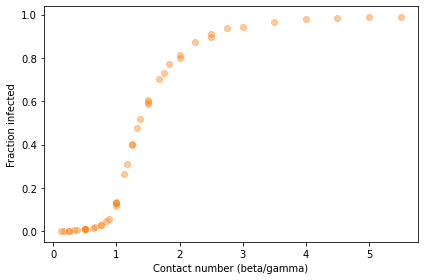

In [57]:
from modsim import decorate

plot_sweep_frame(frame)

decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected')

The results fall on a single curve, at least approximately. That means that we can predict the fraction of students who will be infected based on a single parameter, the ratio `beta/gamma`. We don't need to know the values of `beta` and `gamma` separately.

## Contact number

From Section xxx, recall that the number of new infections in a
given day is $\beta s i N$, and the number of recoveries is
$\gamma i N$. If we divide these quantities, the result is
$\beta s / \gamma$, which is the number of new infections per recovery
(as a fraction of the population).

When a new disease is introduced to a susceptible population, $s$ is
approximately 1, so the number of people infected by each sick person is $\beta / \gamma$. This ratio is called the "contact number\" or "basic reproduction number\" (see <http://modsimpy.com/contact>). By convention it is usually denoted $R_0$, but in the context of an SIR model, this notation is confusing, so we'll use $c$ instead.

The results in the previous section suggest that there is a relationship between $c$ and the total number of infections. We can derive this relationship by analyzing the differential equations from
Section xxx:

$$\begin{aligned}
\frac{ds}{dt} &= -\beta s i \\
\frac{di}{dt} &= \beta s i - \gamma i\\
\frac{dr}{dt} &= \gamma i\end{aligned}$$ 

In the same way we divided the
contact rate by the infection rate to get the dimensionless quantity
$c$, now we'll divide $di/dt$ by $ds/dt$ to get a ratio of rates:

$$\frac{di}{ds} = -1 + \frac{1}{cs}$$ 

Dividing one differential equation by another is not an obvious move, but in this case it is useful because it gives us a relationship between $i$, $s$ and $c$ that does not depend on time. From that relationship, we can derive an equation that relates $c$ to the final value of $s$. In theory, this equation makes it possible to infer $c$ by observing the course of an epidemic.

Here's how the derivation goes. We multiply both sides of the previous
equation by $ds$: 

$$di = \left( -1 + \frac{1}{cs} \right) ds$$ 

And then integrate both sides: 

$$i = -s + \frac{1}{c} \log s + q$$ 

where $q$ is a constant of integration. Rearranging terms yields:

$$q = i + s - \frac{1}{c} \log s$$ 

Now let's see if we can figure out what $q$ is. At the beginning of an epidemic, if the fraction infected is small and nearly everyone is susceptible, we can use the approximations $i(0) = 0$ and $s(0) = 1$ to compute $q$:

$$q = 0 + 1 + \frac{1}{c} \log 1$$ 

Since $\log 1 = 0$, we get $q = 1$.

Now, at the end of the epidemic, let's assume that $i(\infty) = 0$, and $s(\infty)$ is an unknown quantity, $s_{\infty}$. Now we have:

$$q = 1 = 0 + s_{\infty}- \frac{1}{c} \log s_{\infty}$$ 

Solving for $c$, we get $$c = \frac{\log s_{\infty}}{s_{\infty}- 1}$$ By relating $c$ and $s_{\infty}$, this equation makes it possible to estimate $c$ based on data, and possibly predict the behavior of future epidemics.

## Analysis and simulation

Let's compare this analytic result to the results from simulation. I'll create an array of values for $s_{\infty}$

In [58]:
from numpy import linspace

s_inf_array = linspace(0.0001, 0.999, 31)

And compute the corresponding values of $c$:

In [59]:
from numpy import log

c_array = log(s_inf_array) / (s_inf_array - 1)

To get the total infected, we compute the difference between $s(0)$ and
$s(\infty)$, then store the results in a `Series`:

In [60]:
frac_infected = 1 - s_inf_array

Recall from Section [\[dataframe\]](#dataframe){reference-type="ref"
reference="dataframe"} that a `Series` object contains an index and a
corresponding sequence of values. In this case, the index is `c_array`
and the values are from `frac_infected`.

Now we can plot the results:

 compares the analytic results from this
section with the simulation results from
Section [\[nondim\]](#nondim){reference-type="ref" reference="nondim"}.

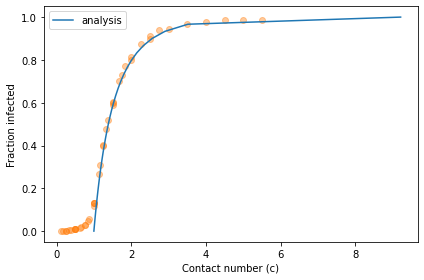

In [61]:
plot_sweep_frame(frame)
plot(c_array, frac_infected, label='analysis')

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected')

When the contact number exceeds 1, analysis and simulation agree. When
the contact number is less than 1, they do not: analysis indicates there should be no infections; in the simulations there are a small number of infections.

The reason for the discrepancy is that the simulation divides time into a discrete series of days, whereas the analysis treats time as a
continuous quantity. In other words, the two methods are actually based on different models. So which model is better?

Probably neither. When the contact number is small, the early progress
of the epidemic depends on details of the scenario. If we are lucky, the original infected person, "patient zero", infects no one and there is no epidemic. If we are unlucky, patient zero might have a large number of close friends, or might work in the dining hall (and fail to observe safe food handling procedures).

For contact numbers near or less than 1, we might need a more detailed
model. But for higher contact numbers the SIR model might be good
enough.

## Estimating contact number

Figure xxx shows that if we know the contact number, we can compute the fraction infected. But we can also read the figure the other way; that is, at the end of an epidemic, if we can estimate the fraction of the population that was ever infected, we can use it to estimate the contact number.

Well, in theory we can. In practice, it might not work very well,
because of the shape of the curve. When the contact number is near 2,
the curve is quite steep, which means that small changes in $c$ yield
big changes in the number of infections. If we observe that the total
fraction infected is anywhere from 20% to 80%, we would conclude that
$c$ is near 2.

On the other hand, for larger contact numbers, nearly the entire
population is infected, so the curve is nearly flat. In that case we
would not be able to estimate $c$ precisely, because any value greater
than 3 would yield effectively the same results. Fortunately, this is
unlikely to happen in the real world; very few epidemics affect anything close to 90% of the population.

So the SIR model has limitations; nevertheless, it provides insight into the behavior of infectious disease, especially the phenomenon of herd immunity. As we saw in Chapter xxx, if we know the parameters of the model, we can use it to evaluate possible interventions. And as we saw in this chapter, we might be able to use data from earlier outbreaks to estimate the parameters.


## Exercises

**Exercise:**  If we didn't know about contact numbers, we might have explored other possibilities, like the difference between `beta` and `gamma`, rather than their ratio.

Write a version of `plot_sweep_frame`, called `plot_sweep_frame_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply? 

In [62]:
# Solution

def plot_sweep_frame_difference(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            frac_infected = column[beta]
            plot(beta - gamma, frac_infected, 'ro', 
                 color='C1', alpha=0.4)

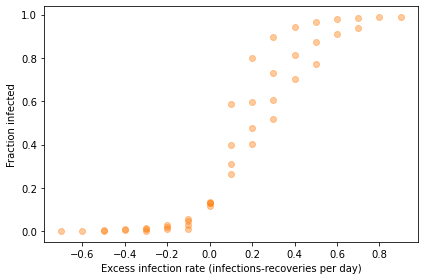

In [63]:
# Solution

plot_sweep_frame_difference(frame)

decorate(xlabel='Excess infection rate (infections-recoveries per day)',
         ylabel='Fraction infected')

In [64]:
# Solution

# The results don't fall on a line, which means that if we 
# know the difference between `beta` and `gamma`, 
# but not their ratio, that's not enough to predict 
# the fraction infected.

**Exercise:** Suppose you run a survey at the end of the semester and find that 26% of students had the Freshman Plague at some point.

What is your best estimate of `c`?

Hint: if you print `frac_infected_series`, you can read off the answer. 

In [66]:
# Solution

from pandas import Series

Series(frac_infected, index=c_array)

9.211261    0.999900
3.516747    0.966603
2.901137    0.933307
2.558511    0.900010
2.325167    0.866713
2.150496    0.833417
2.012246    0.800120
1.898689    0.766823
1.802908    0.733527
1.720492    0.700230
1.648460    0.666933
1.584709    0.633637
1.527703    0.600340
1.476285    0.567043
1.429566    0.533747
1.386847    0.500450
1.347569    0.467153
1.311281    0.433857
1.277610    0.400560
1.246247    0.367263
1.216935    0.333967
1.189452    0.300670
1.163613    0.267373
1.139256    0.234077
1.116242    0.200780
1.094449    0.167483
1.073772    0.134187
1.054117    0.100890
1.035401    0.067593
1.017551    0.034297
1.000500    0.001000
dtype: float64

In [21]:
# Solution

# It looks like the fraction infected is 0.26 when the contact 
# number is about 1.16